# Homework 3: Reproducibility in Climate Studies

* **Statistics 159/259, Spring 2022**
* **Due 03/23/2023, 23:59PM PT**
* Prof. F. Pérez and GSI F. Sapienza, Department of Statistics, UC Berkeley.
* This assignment is worth a maximum of **50 points**.
* Assignment type: **group homework assignment** (Check on Ed Discussion about group's assignments).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

from pathlib import Path
from scipy.interpolate import CubicSpline

# Small style adjustments for more readable plots
plt.style.use("seaborn-whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["font.size"] = 14

/tmp/ipykernel_316/1417279790.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


## 1. The Manua Loa CO2 data [15 points] 

For this first section, we will focus in reproducing Keeling's curve: 

<img src="figures/annual-anomaly-orig.png" width="700px" />

We start by loading the same dataset we used during the lecture, containing CO2 measurements in Mauna Loa, Hawaii. We get rid of missing values that are set to -99.99 and then drop from the dataset. Notice that the data for this homework has being already uploaded in our shared folder. 

In [2]:
DATA_DIR = Path.home()/Path('shared/climate-data')

co2_file = DATA_DIR / "monthly_in_situ_co2_mlo_cleaned.csv"
data = pd.read_csv(co2_file, na_values=-99.99).dropna()
data.head()

,year,month,date_index,fraction_date,c02,data_adjusted_season,data_fit,data_adjusted_seasonally_fit,data_filled,data_adjusted_seasonally_filed
2,1958,3,21259,1958.2027,315.70,314.43,316.19,314.90,315.70,314.43
3,1958,4,21290,1958.2877,317.45,315.16,317.30,314.98,317.45,315.16
4,1958,5,21320,1958.3699,317.51,314.71,317.86,315.06,317.51,314.71
6,1958,7,21381,1958.5370,315.86,315.19,315.86,315.22,315.86,315.19
7,1958,8,21412,1958.6219,314.93,316.19,313.99,315.29,314.93,316.19


This is how the data look like

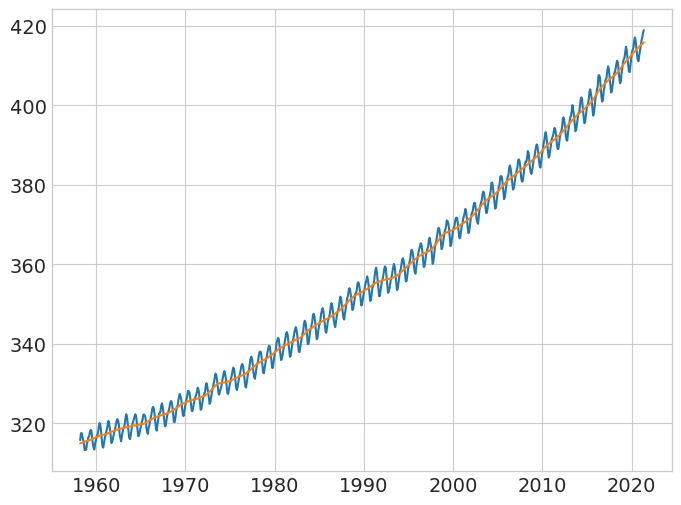

In [3]:
plt.plot("fraction_date", "c02", data=data)
plt.plot("fraction_date", "data_adjusted_seasonally_fit", data=data);

We are going to try to understand the annual variability on top of the growing trend, and see whether that variability is itself changing over time or not.

The figure above shows an annual cycle, alongside with perhaps some variability in it. Plants take up CO2 in (northern) spring/summer then release in fall/winter --- so the release is getting stronger. 

Let's try to estimate the increase in amplitude of annual cycle. A quick and simple `groupby` operation and removal of the annual mean result in this simple plot:

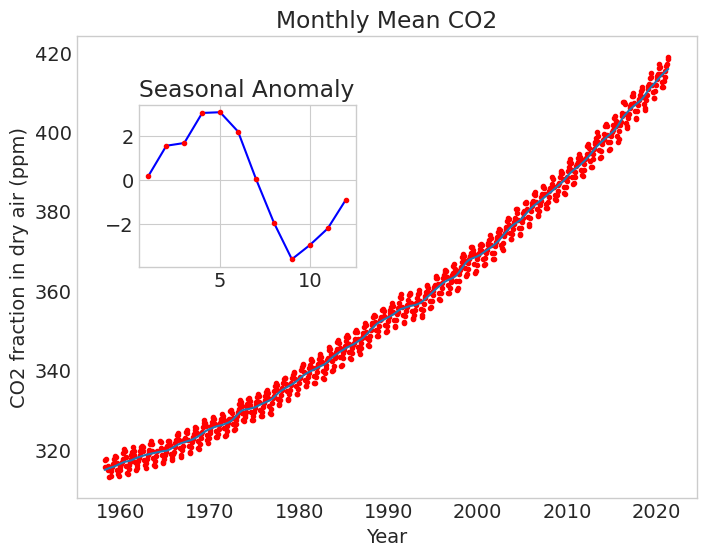

In [4]:
# calculate the anual cucle using groupby
annual = data.groupby(data.month).mean()

# calculate the anomaly
anomaly = annual - annual.mean()

# plot
fig, ax = plt.subplots()

ax.plot("fraction_date", "data_filled", "r.", data=data)
ax.plot("fraction_date", "data_adjusted_seasonally_fit", data=data)
ax.set_xlabel("Year")
ax.set_ylabel("CO2 fraction in dry air (ppm)")
ax.set_title("Monthly Mean CO2")
ax.grid(False)

axin1 = ax.inset_axes([0.1, 0.5, 0.35, 0.35])
axin1.plot(anomaly.c02, "b")
axin1.plot(anomaly.c02, "r.")
axin1.set_title("Seasonal Anomaly");

But if you look closely, that figure isn't quite the same as the one shown at the top. You can observe that the monthly variability is more smooth in the original figure and that is slightly shifted too. 

We'll start by trying to understand the monthly data. The following shows us the data for all the years, by month:

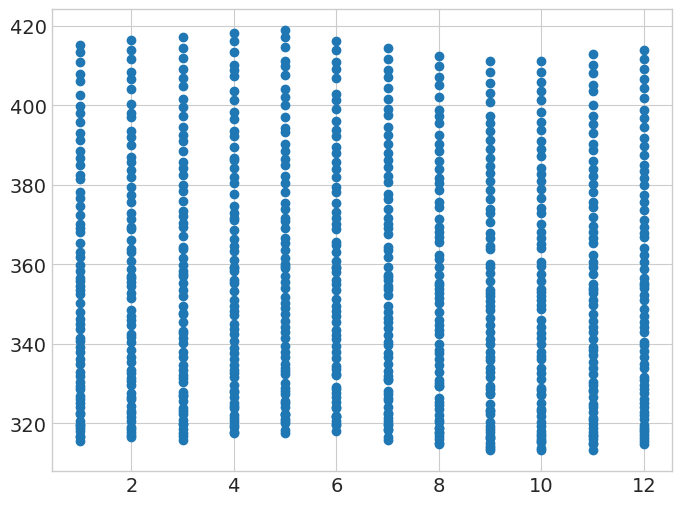

In [5]:
plt.scatter('month', 'c02', data=data);

Unfortunately it's hard to see what's actually going on here.

### Question 1 [5 points]

Recreate the following figure, that shows the monthly cycle for all the years in the dataset:

<img src="figures/monthly-cycles-co2.png" width="700px" />

Hint: Use `sns.lineplot(...)`

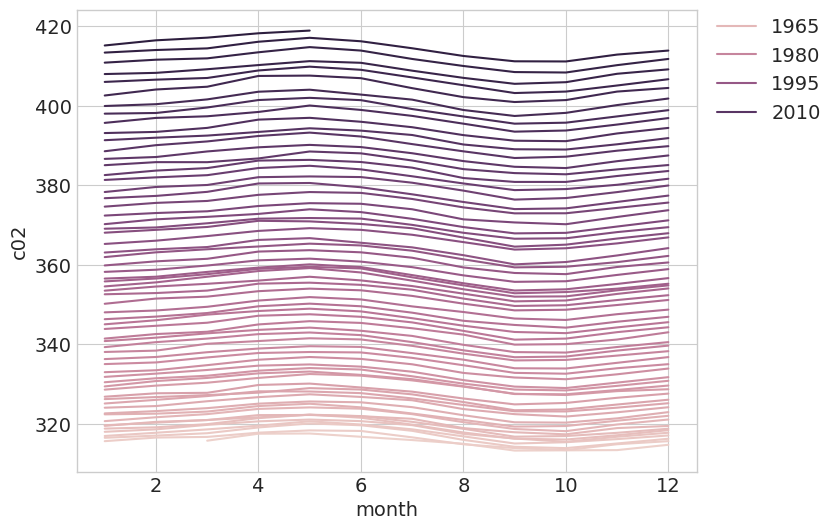

In [6]:
# creating lineplot
sns.lineplot(data, x = 'month', y = 'c02', hue = 'year')

# moving the legend outside top right corner of plot
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

### Question 2 [5 points]

Next, in order to recreate the figure in the talk, we're going to find the monthly anomaly averaging across years. You should end up with the following data frame after writing your function and running the cell (only the first few months are shown, it should have data for all 12 months):

<img src="figures/monthly-co2-anomaly-df.png" width="150px" />

In order to do so, you will have to remove the annual average and use that to identify the monthly trend. Here some clue of how to do this, but feel free to explore other options:

In [10]:
def detrend(f):
    detrended_xarr = f[["month", "c02"]].set_index(["month"]).to_xarray()
    v = detrended_xarr - detrended_xarr.mean("month")
    return v.to_dataframe() 

dy = data.groupby('year')
c02anomaly = dy.apply(detrend)
display(c02anomaly)
monthly_anomaly = c02anomaly.groupby('month').mean()[['c02']]
monthly_anomaly

c02
year month        
1958 3      0.3675
     4      2.1175
     5      2.1775
     7      0.5275
     8     -0.4025
...            ...
2021 1     -2.0180
     2     -0.7180
     3     -0.0480
     4      1.0520
     5      1.7320

[754 rows x 1 columns]

,c02
month,
1,-0.683835
2,0.076121
3,0.874238
4,2.240270
5,2.864155
6,2.299297
7,0.792919
8,-1.195018
9,-2.851367


You can test the output of your result by

In [11]:
assert list(monthly_anomaly['c02']) == [-0.6838350970017644, 0.07612096774193428, 0.8742380952380925,
                                        2.240269841269833, 2.8641545138888853, 2.299296594982075, 
                                        0.792918871252205, -1.1950176366843068, -2.851366843033514, 
                                       -2.8573163082437323, -1.453271604938272, -0.15930335097002282]

### Question 3 [5 points]

Next, recreate the following figure, which is much closer to the one in the lecture:

<img src="figures/annual-anomaly-new.png" width="700px" />

**Hints:** 
- in order to get that smooth curve, you'll need to use `from scipy.interpolate import CubicSpline`. You can find the documentation for `CubicSpline` [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CubicSpline.html).
- The "Seasonal Anomaly" inset graph can be created with `ax.inset_axes(...)`. You can treat the `Axes` object returned like any other `Axes` object.
- Remember that you can set the tick labels with `ax.set_xticks(...)`.
- To get the data points plotted as red dots, when you use `ax.plot(...)`, pass in `"r."` as the argument immediately following any data you pass in. The `"r"` indicates the color, while the `"."` indicates how the data will be plotted (if you don't put the `"."`, it will be a line instead).

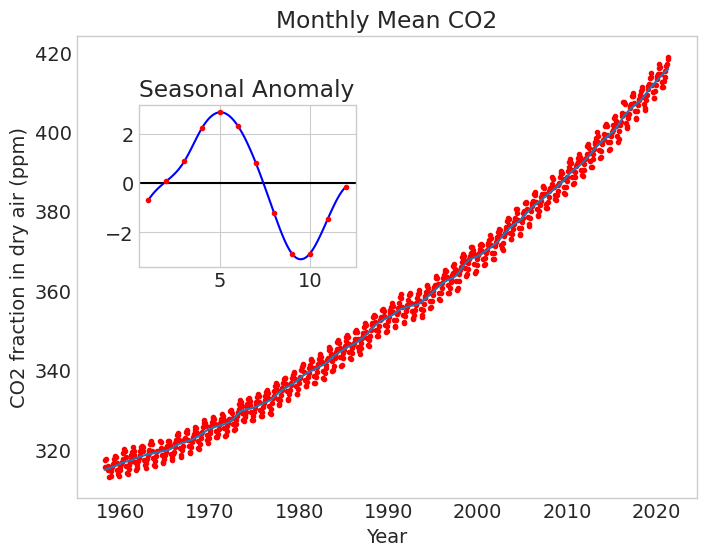

In [17]:
fig, ax = plt.subplots()

# Monthly Mean CO2
ax.plot("fraction_date", "data_filled", "r.", data=data)
ax.plot("fraction_date", "data_adjusted_seasonally_fit", data=data) 
ax.set_xlabel("Year")
ax.set_ylabel("CO2 fraction in dry air (ppm)")
ax.set_title("Monthly Mean CO2")
ax.grid(False)

# Subplot for the seasonal anomaly 
axin1 = ax.inset_axes([0.1, 0.5, 0.35, 0.35])
axin1.axhline(0, color = 'black') 
axin1.plot(np.linspace(1, 12, 100), 
           CubicSpline(np.arange(1, 13), monthly_anomaly.c02)(np.linspace(1, 12, 100)), "b")
axin1.plot(np.arange(1, 13), monthly_anomaly.c02, "r.")
axin1.set_title("Seasonal Anomaly");

## 2. The West Coast Heat Wave

In 2016 [Dr. Chelle Gentemann](https://cgentemann.github.io) and collaborators published a [paper](https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2016GL071039) on the heat wave in the ocean off the California coast

The analysis was then performed using Matlab to process scientific data. To make Figure 1, here are the following steps:
- Download 4 TB of data from NASA PO.DAAC data archive via FTP
- Go through each day of data and subset to the West Coast Region to reduce size and save each subsetted day
- Go through 2002-2012 and create a daily climatology and save all 365 days of the climatology
- Go through each day of data and calculate the anomaly and save each day's anomaly

This whole process took about 1-2 month. 
Below we will do this using MUR SST data on AWS Open Data Program in a few minutes using Python.

In [18]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import fsspec

import xarray as xr
xr.set_options(display_style="html")  # display dataset nicely

import warnings
warnings.simplefilter("ignore")  # filter some warning messages

# code features from https://scitools.org.uk/cartopy/docs/v0.14/matplotlib/feature_interface.html
crs = ccrs.PlateCarree()  # set projection

Subset all the data to just the West Coast region

In [19]:
ds = xr.open_dataset("~/shared/climate-data/ds_hw.nc")
ds

<xarray.Dataset>
Dimensions:           (time: 6443, lat: 251, lon: 234)
Coordinates:
  * lat               (lat) float32 33.0 33.06 33.12 33.18 ... 47.88 47.94 48.0
  * lon               (lon) float32 -132.0 -131.9 -131.9 ... -118.1 -118.0
  * time              (time) datetime64[ns] 2002-06-01T09:00:00 ... 2020-01-2...
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:                CF-1.7
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    MUR = "Multi-scale Ultra-high Resolution"
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    ...                         ...
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    time_coverage_end:          20200116T210000Z
    time_coverage_start:        20200115T210000Z
    title:                      Daily MUR SST, Final product
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0

This is how a rough version of one of the plots in the paper look like

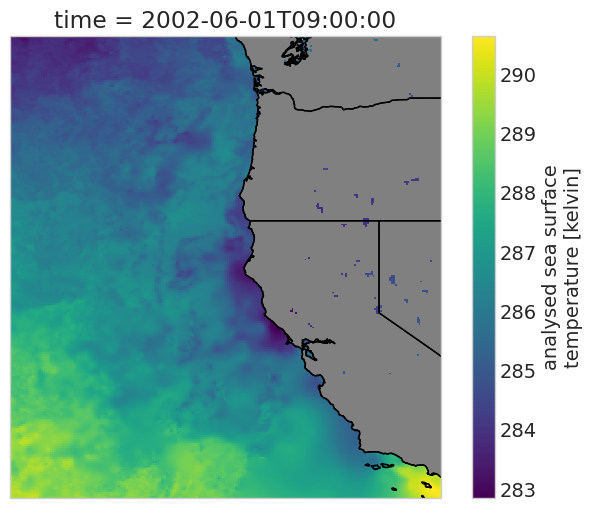

In [32]:
ds.analysed_sst[0, :, :].plot()

# Plot on a map
ax = plt.subplot(projection=crs)
ds.analysed_sst[0, :, :].plot(ax=ax, transform=crs)
ax.coastlines("10m", color="k")
ax.add_feature(cfeature.LAND, color="grey")
ax.add_feature(cfeature.STATES.with_scale("10m"))

### Question 4 [10 points]

Reproduce Figure 1 in the paper. When doing that, try to slice data using `xarray` in the most clear and reproducible way (for example, don't use indices to access data objects like we did in the example above).

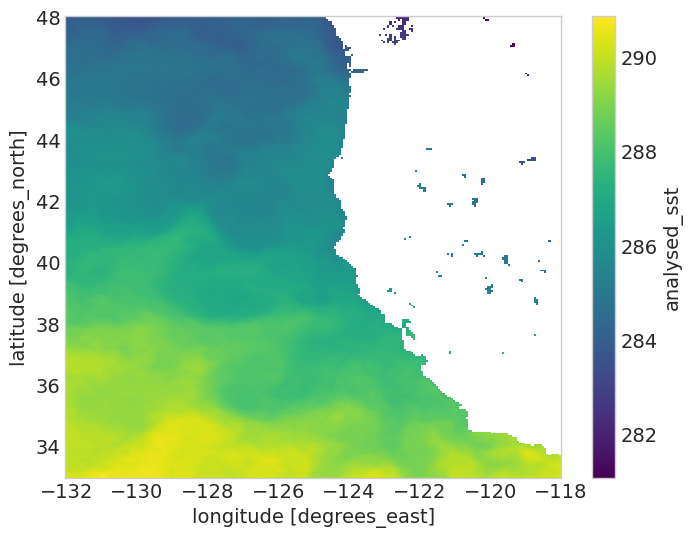

In [35]:
i=1
j=1
timestr=f"20{14+i}-{j+1:02d}"
ds.sel(time=timestr).analysed_sst.mean("time").plot()

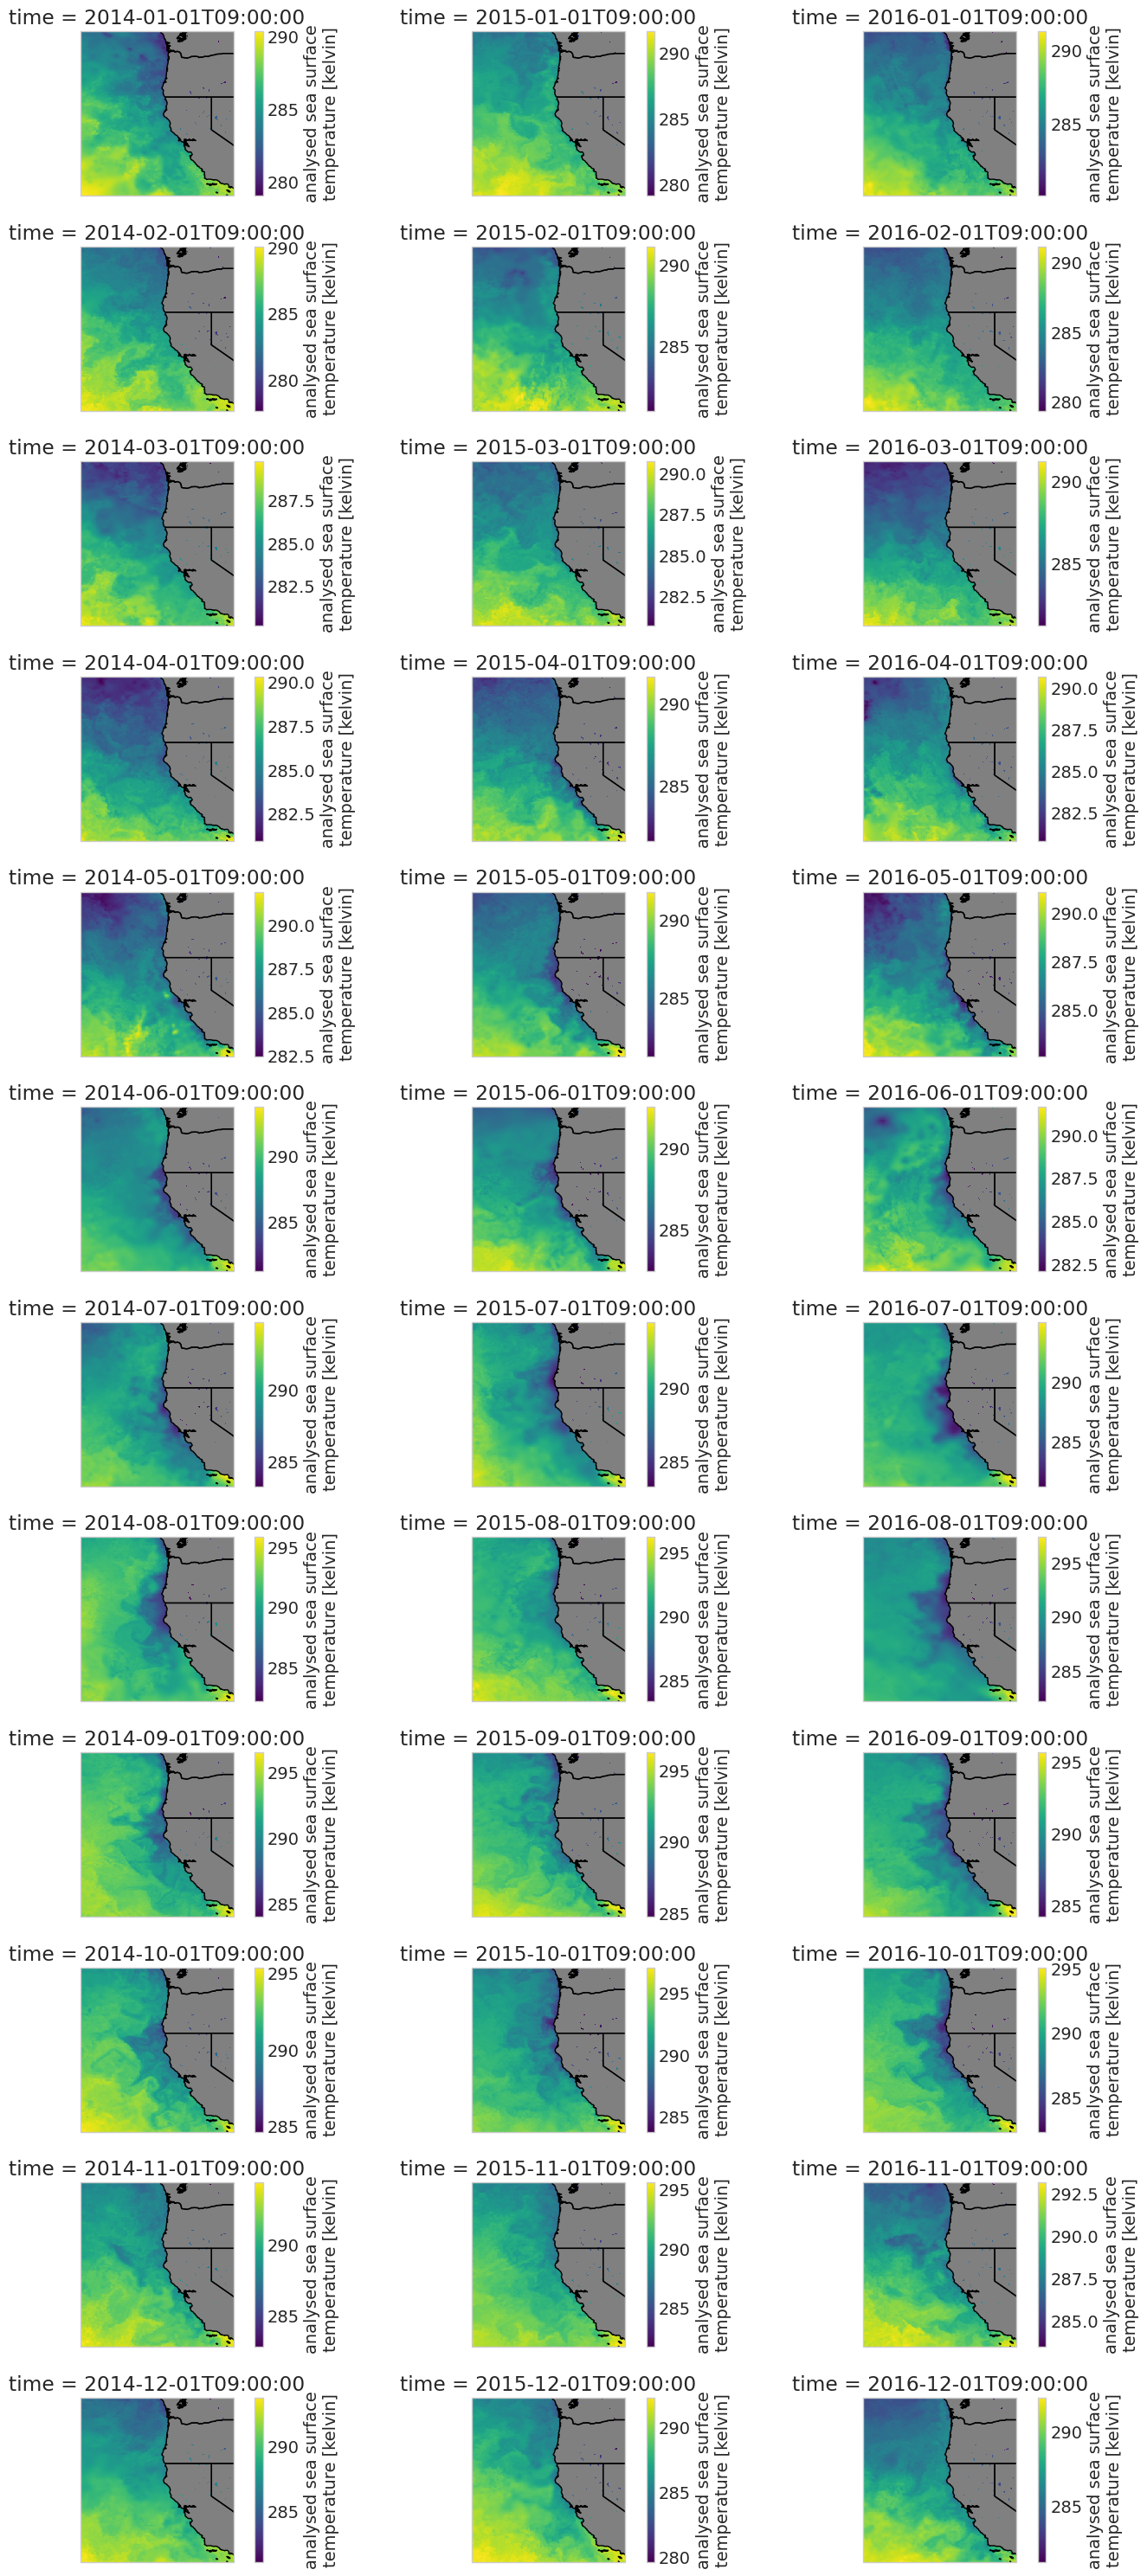

In [36]:
nrows=12
ncols=3

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(15, 30))
for i in range(ncols):
    for j in range(nrows):
        timestr=f"20{14+i}-{j+1:02d}"
        # Using "nearest" because sometimes there are multiple time values in a given month
        ds.sel(time=timestr, method="nearest").analysed_sst.plot(ax=axs[j, i]) 
        axs[j, i].add_feature(cfeature.LAND, color="grey")
        axs[j, i].add_feature(cfeature.STATES.with_scale("10m"))
fig.tight_layout();

### Question 5 [10 points]

Reproduce one of the images in Figure 2. If you feel adventurous, you can make more than one!

In [47]:
#ds.sel(time=slice("2002-06", "2016-07")).groupby(ds.time.dt.month)

### Question 6 [10 points]

Reproduce one of the images in Figure 3. 

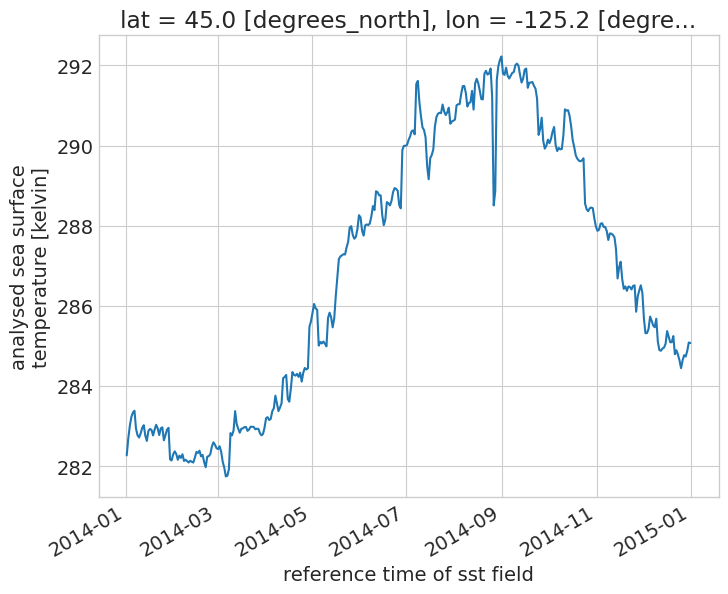

In [96]:
# longtitude of Newport 1000km offshore is approximately 125.16°W

lat_45_year_2014 = ds.sel(lat=45, time = "2014")
lat_45_year_2014.analysed_sst.sel(lon = -125.16, method = "nearest").plot();

#lat_45_year_2015 = ds.sel(lat=45, time = "2015")
#lat_45_year_2015.analysed_sst.sel(lon = -125.16, method = "nearest").plot();

#lat_45_by_year = lat_45.groupby(ds.time.dt.year)